In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
COINBASE = '/content/drive/MyDrive/Colab Notebooks/data/coinbase.csv'
BITSTAMP = '/content/drive/MyDrive/Colab Notebooks/data/bitstamp.csv'

In [3]:
def preprocess_data(data):
    # Select only the 'Timestamp' and 'Weighted_Price' columns
    data = data[['Timestamp', 'Weighted_Price']].copy()

    # Convert Unix time to datetime
    data.loc[:, 'Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

    # Set datetime as index
    data.set_index('Timestamp', inplace=True)

    # Drop any NaN values
    data.dropna(inplace=True)

    # Resample data to hourly intervals
    data = data.resample('H').mean()

    # Rescale the data
    scaler = MinMaxScaler()
    data.loc[:, :] = scaler.fit_transform(data)

    return data

def main():
    # Load the data
    coinbase_data = pd.read_csv(COINBASE)
    bitstamp_data = pd.read_csv(BITSTAMP)

    # Preprocess the data
    coinbase_data = preprocess_data(coinbase_data)
    bitstamp_data = preprocess_data(bitstamp_data)

    # Save the preprocessed data
    coinbase_data.to_csv('coinbase_preprocessed.csv', index=True)
    bitstamp_data.to_csv('bitstamp_preprocessed.csv', index=True)

if __name__ == "__main__":
    main()

Epoch 1/10
2876/2876 - 48s - loss: nan - val_loss: nan - 48s/epoch - 17ms/step
Epoch 2/10
2876/2876 - 36s - loss: nan - val_loss: nan - 36s/epoch - 13ms/step
Epoch 3/10
2876/2876 - 39s - loss: nan - val_loss: nan - 39s/epoch - 14ms/step
Epoch 4/10
2876/2876 - 38s - loss: nan - val_loss: nan - 38s/epoch - 13ms/step
Epoch 5/10
2876/2876 - 40s - loss: nan - val_loss: nan - 40s/epoch - 14ms/step
Epoch 6/10
2876/2876 - 36s - loss: nan - val_loss: nan - 36s/epoch - 13ms/step
Epoch 7/10
2876/2876 - 34s - loss: nan - val_loss: nan - 34s/epoch - 12ms/step
Epoch 8/10
2876/2876 - 35s - loss: nan - val_loss: nan - 35s/epoch - 12ms/step
Epoch 9/10
2876/2876 - 38s - loss: nan - val_loss: nan - 38s/epoch - 13ms/step
Epoch 10/10
2876/2876 - 35s - loss: nan - val_loss: nan - 35s/epoch - 12ms/step


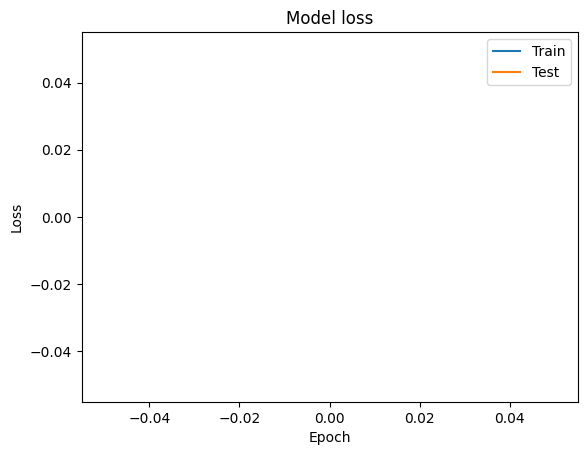

719/719 [==============================] - 3s 5ms/step - loss: nan
Test Loss: nan


In [14]:
def create_dataset(data, look_back=24):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

def main():
    # Load the preprocessed data
    coinbase_data = pd.read_csv('coinbase_preprocessed.csv', index_col='Timestamp', parse_dates=True)
    bitstamp_data = pd.read_csv('bitstamp_preprocessed.csv', index_col='Timestamp', parse_dates=True)

    # Create the dataset
    X, Y = create_dataset(coinbase_data.values)

    # Split the data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Convert the data to tf.data.Dataset
    train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    test_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

    # Create the model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss=MeanSquaredError())

    # Train the model
    history = model.fit(train_data.batch(10), epochs=10, verbose=2, validation_data=test_data.batch(10))

    # Plot the training loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

    # Evaluate the model
    test_loss = model.evaluate(test_data.batch(10))
    print(f'Test Loss: {test_loss}')

if __name__ == "__main__":
    main()